In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
saraabduljabbar_faintsetv2_open_path = kagglehub.dataset_download('saraabduljabbar/faintsetv2-open')

print('Data source import complete.')

Using Colab cache for faster access to the 'faintsetv2-open' dataset.
Data source import complete.


In [ ]:
!pip install mediapipe==0.10.14

In [ ]:
import os
import glob
import cv2
import math
import numpy as np
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from google.colab import files
from collections import Counter, defaultdict

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/saraabduljabbar/faintsetv2-open/versions/1/Dataset"

print("Dataset path set to:", dataset_path)
print("Subfolders:", os.listdir(dataset_path))

Dataset path set to: /root/.cache/kagglehub/datasets/saraabduljabbar/faintsetv2-open/versions/1/Dataset
Subfolders: ['faint', 'normal']


In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    smooth_landmarks=True,
    enable_segmentation=False,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.3
)

def extract_keypoints_from_video(video_path, frame_skip=2):
    cap = cv2.VideoCapture(str(os.path.abspath(video_path)))
    keypoints_list = []
    frame_count = 0
    detected_frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % frame_skip != 0:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            detected_frames += 1
            landmarks = results.pose_landmarks.landmark
            keypoints = []
            for lm in landmarks:
                keypoints.append(lm.x)
                keypoints.append(lm.y)
            keypoints_list.append(keypoints)
        else:
            keypoints_list.append(np.zeros(66))

    cap.release()
    print(f"{os.path.basename(video_path)}: {frame_count} total, {detected_frames} detected")
    return np.array(keypoints_list)

all_data = {}

for label in sorted(os.listdir(dataset_path)):
    label_dir = os.path.join(dataset_path, label)
    if not os.path.isdir(label_dir):
        continue

    print(f"\n🔹 Processing label: {label}")
    all_data[label] = {}

    # recursively find all .mp4 files two levels deep
    for video_file in glob.glob(os.path.join(label_dir, "**", "*.mp4"), recursive=True):
        keypoints_seq = extract_keypoints_from_video(video_file)
        all_data[label][os.path.basename(video_file)] = keypoints_seq

print("\nExtraction finished for all videos (recursive search).")



🔹 Processing label: faint


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


09.mp4: 92 total, 46 detected
23.mp4: 44 total, 13 detected
26.mp4: 101 total, 49 detected
95.mp4: 402 total, 67 detected
104.mp4: 346 total, 72 detected
109.mp4: 349 total, 140 detected
06.mp4: 113 total, 53 detected
76.mp4: 256 total, 117 detected
13.mp4: 122 total, 60 detected
70.mp4: 937 total, 376 detected
101.mp4: 543 total, 241 detected
73.mp4: 495 total, 210 detected
05.mp4: 139 total, 68 detected
89.mp4: 1143 total, 254 detected
92.mp4: 637 total, 277 detected
12.mp4: 174 total, 84 detected
46.mp4: 138 total, 67 detected
106.mp4: 520 total, 253 detected
121.mp4: 626 total, 268 detected
84.mp4: 282 total, 107 detected
62.mp4: 103 total, 48 detected
75.mp4: 340 total, 170 detected
96.mp4: 926 total, 364 detected
48.mp4: 110 total, 54 detected
90.mp4: 393 total, 139 detected
42.mp4: 97 total, 42 detected
37.mp4: 116 total, 57 detected
88.mp4: 1144 total, 241 detected
79.mp4: 496 total, 172 detected
54.mp4: 101 total, 49 detected
27.mp4: 66 total, 14 detected
43.mp4: 93 total, 45 

In [ ]:
# Prepare the dataset for LSTM training
# Define how many frames will form one input sequence for the LSTM
WINDOW_SIZE = 10

# Initialize empty lists for input data (X) and labels (y)
X, y = [], []

# Loop through each class label (for example "faint" and "normal") in the extracted keypoints
for label, videos in all_data.items():
    # Loop through every video belonging to that label
    for vname, keypoints_seq in videos.items():
        # Ensure that the video has at least WINDOW_SIZE frames
        if len(keypoints_seq) >= WINDOW_SIZE:
            # Create sequential windows of pose keypoints
            for i in range(0, len(keypoints_seq) - WINDOW_SIZE + 1, WINDOW_SIZE):
                window = keypoints_seq[i:i+WINDOW_SIZE]  # extract a window of frames
                X.append(window)  # add the window to the dataset
                # Assign a numeric label: 0 for faint, 1 for normal
                y.append(0 if label == "faint" else 1)

# Convert the lists into numpy arrays for training
X = np.array(X)
y = np.array(y)

# Print dataset information for verification
print("Dataset ready for LSTM")
print("X shape:", X.shape)
print("y shape:", y.shape)

Dataset ready for LSTM
X shape: (11931, 10, 66)
y shape: (11931,)


In [ ]:
# Split the dataset into training and validation and test sets
# Use stratified split to maintain class balance between training and validation sets
# First split train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Split temp into val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, " | ", Counter(y_train))
print("Val  :", X_val.shape,   " | ", Counter(y_val))
print("Test :", X_test.shape,  " | ", Counter(y_test))


Train: (8351, 10, 66)  |  Counter({np.int64(1): 6803, np.int64(0): 1548})
Val  : (2386, 10, 66)  |  Counter({np.int64(1): 1943, np.int64(0): 443})
Test : (1194, 10, 66)  |  Counter({np.int64(1): 973, np.int64(0): 221})


In [ ]:
# Build the LSTM model
# Create a sequential Keras model
model = Sequential([
    # LSTM layer with 64 hidden units, expecting input of shape (WINDOW_SIZE, 66)
    LSTM(64, input_shape=(WINDOW_SIZE, 66), return_sequences=False),
    # Dropout layer to reduce overfitting by randomly disabling 30% of neurons
    Dropout(0.3),
    # Dense layer with 32 neurons and ReLU activation for nonlinear feature learning
    Dense(32, activation='relu'),
    # Output layer with 2 neurons (faint and normal) and softmax activation for classification
    Dense(2, activation='softmax')
])

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # validate during training
    epochs=30,                       # number of training epochs
    batch_size=16,                   # number of samples per gradient update
    verbose=1                        # display training progress
)

Epoch 1/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8178 - loss: 0.4660 - val_accuracy: 0.8474 - val_loss: 0.3694
Epoch 2/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8556 - loss: 0.3566 - val_accuracy: 0.8588 - val_loss: 0.3317
Epoch 3/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8707 - loss: 0.3157 - val_accuracy: 0.8692 - val_loss: 0.3101
Epoch 4/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8844 - loss: 0.2905 - val_accuracy: 0.8546 - val_loss: 0.3284
Epoch 5/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8873 - loss: 0.2777 - val_accuracy: 0.8722 - val_loss: 0.3004
Epoch 6/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8908 - loss: 0.2670 - val_accuracy: 0.8826 - val_loss: 0.2714
Epoch 7/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8998 - loss: 0.2429 - val_accuracy: 0.8797 - val_loss: 0.2726
Epoch 8/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9017 - loss: 0.2294 - val_accuracy: 0.

In [ ]:
# Predict on the validation set
y_pred = np.argmax(model.predict(X_val), axis=1)

# Calculate overall accuracy score
acc = accuracy_score(y_val, y_pred)
print("\nValidation Accuracy:", round(acc*100, 2), "%")

# Display precision, recall, and F1-score for each class
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["faint", "normal"]))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Validation Accuracy: 91.74 %

Classification Report:
              precision    recall  f1-score   support

       faint       0.83      0.70      0.76       443
      normal       0.93      0.97      0.95      1943

    accuracy                           0.92      2386
   macro avg       0.88      0.83      0.85      2386
weighted avg       0.91      0.92      0.91      2386



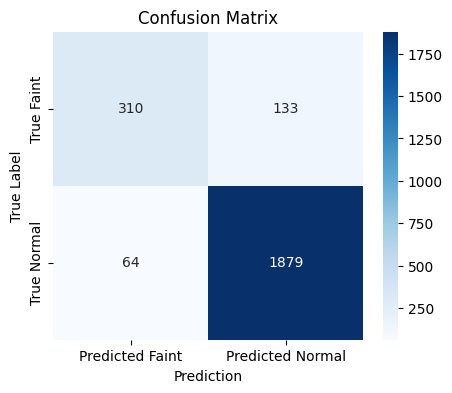

In [ ]:
# Compute the confusion matrix between actual and predicted labels
cm = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Faint","Predicted Normal"],
            yticklabels=["True Faint","True Normal"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Accuracy: 93.63 %

Classification report:
              precision    recall  f1-score   support

      normal       0.87      0.77      0.82       221
       faint       0.95      0.97      0.96       973

    accuracy                           0.94      1194
   macro avg       0.91      0.87      0.89      1194
weighted avg       0.93      0.94      0.93      1194



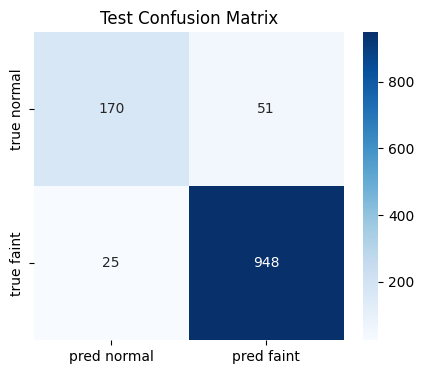

In [ ]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_test_pred)*100, 2), "%")
print("\nClassification report:")
print(classification_report(y_test, y_test_pred, target_names=["normal","faint"]))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred normal","pred faint"],
            yticklabels=["true normal","true faint"])
plt.title("Test Confusion Matrix")
plt.show()

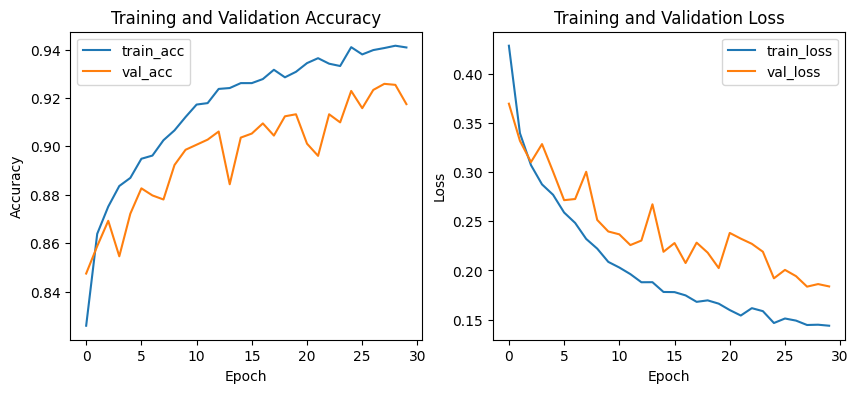

In [ ]:
# Plot Accuracy and Loss Curves
# Plot training vs validation accuracy and loss curves
plt.figure(figsize=(10,4))

# Plot accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save("faint_detection_model.h5")

In [ ]:
model_path = "/content/faint_detection_model.h5"
model = load_model(model_path)
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Function to generate labeled video
def predict_and_save(video_path, model, output_path="predicted_output.mp4",
                     window_size=10, frame_skip=2):
    # Open video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: cannot open video file.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Set up video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    keypoints_buffer = []
    current_prediction = "Analyzing..."

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        # Skip frames if needed for speed
        if frame_idx % frame_skip != 0:
            continue

        # Convert frame for MediaPipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        # Extract keypoints if pose is detected
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            keypoints = [coord for lm in landmarks for coord in (lm.x, lm.y)]
            keypoints_buffer.append(keypoints)
        else:
            keypoints_buffer.append(np.zeros(66))

        # Maintain a fixed-length buffer
        if len(keypoints_buffer) > window_size:
            keypoints_buffer = keypoints_buffer[-window_size:]

        # Run prediction when buffer is full
        if len(keypoints_buffer) == window_size:
            seq = np.array(keypoints_buffer).reshape(1, window_size, 66)
            pred = model.predict(seq, verbose=0)
            label_idx = np.argmax(pred)
            conf = np.max(pred)
            current_prediction = f"FAINT ({conf*100:.1f}%)" if label_idx == 0 else f"NORMAL ({conf*100:.1f}%)"

        # Overlay prediction text on frame
        color = (0, 0, 255) if "FAINT" in current_prediction else (0, 255, 0)
        cv2.putText(frame, current_prediction, (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3, cv2.LINE_AA)

        # Write frame to output video
        out.write(frame)

    cap.release()
    out.release()
    print(f"Output video saved as: {output_path}")


In [ ]:
# Example usage NORMAL
normal_video = "/content/1093.mp4"
output_video = "predicted_output(NORMAL).mp4"

predict_and_save(normal_video, model, output_video)

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Output video saved as: predicted_output(NORMAL).mp4


In [ ]:
files.download(output_video)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example usage FAINT
faint_video  = "/content/cam1.mp4"
output_video = "predicted_output(FAINT).mp4"

predict_and_save(faint_video, model, output_video)

Output video saved as: predicted_output(FAINT).mp4


In [ ]:
files.download(output_video)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>